# Automatic evaluation script for VLM

Steps:
1. Extract keywords
2. Classify keywords
3. Score keywords

### Load the required Libraries

In [1]:
!pip install accelerate
!pip install transformers>=4.36
!pip install optimum
#!pip install bitsandbytes
#!pip install aqlm[gpu,cpu]
!pip install auto-gptq
#!pip install autoawq

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
  Using cached safetensors-0.4.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Usi

### Step 1 Prompt structure

In [2]:
def get_prompt_1(input):
    prompt1 = f'''Perform the task according to the task description. DO NOT return any extra text or explanation
Task Description:
Take the input and extract words which refer to class, family, or species of the animal. Enclose the result between following tags: <RESULT> </RESULT>
Example 1:
Input:
A peacock is a large, colorful bird known for its distinctive plumage and elaborate tail feathers.
Output:
<RESULT>peacock, bird</RESULT>
Example 2:
Input:
The bald eagle is a bird of prey found in North America. It has a white head and tail with a dark brown body and wings.
Output:
<RESULT>Bald eagle, bird</RESULT>
Example 3:
Input:
a large, long-legged bird, possibly a type of ostrich or emu. These birds are known for their distinctive appearance and long legs, which enable them to run at high speeds.
Output:
<RESULT>bird, ostrich, emu</RESULT>
Your Turn:
Input:
{input}
Output:
'''
    return prompt1

### Step 2 Prompt structure

In [3]:
def get_prompt_2(input):
    prompt2 = f'''Perform the task according to the task description. DO NOT return any extra text or explantion.
Task Description: For the given keywords, classify them into following groups: class of animal, family of animal, species of animal. Enclose the result between following tags: <RESULT> </RESULT>
Example 1:
Input:
Keywords: peacock, bird
Output:
<RESULT>
Class: bird
Family: peacock
Species: None
</RESULT>
Example 2:
Input:
Keywords: Bald eagle, bird
Output:
<RESULT>
Class: bird
Family: None
Species: Bald eagle
</RESULT>
Example 3:
Input:
Keywords: bird, ostrich, emu
Output:
<RESULT>
Class: bird
Family: ostrich, emu
Species: None
</RESULT>
Your Turn:
Input:
{input}
Output:
'''
    return prompt2

### Step 3 Prompt structure

In [4]:
def get_prompt_3(input, ground_truth):
    prompt3 = f'''
    Perform the task according to the task description. DO NOT return any extra text or explantion.
    Task Description:
    Evaluate the input based on the following score rubric and ground truth. For each criterion, 
    assign the appropriate score and provide a brief justification. Enclose the result between following tags: <RESULT> </RESULT>
    
    Score Rubric:
    S1: Does the model identify the class of the animal?
    1: for correct
    0: for none
    -1: for incorrect
    S2: Does the model identify the family of the animal?**
    1: for correct
    0: for none
    -1: for incorrect
    S3: Does the model identify the species of the animal?**
    1: for correct
    0: for none
    -1: for incorrect
    
    Example 1:
    Input:
    Class: bird, Family: None, Species: Great Bustard
    
    Ground Truth:
    Class: Bird, Family: Bustard, Species: Great Bustard
    
    Output:
    Scores and Justifications:
    S1: 1 (Correctly identifies the class as "bird")
    S2: 0 (Does not identify the family)
    S3: 1 (Correctly identifies the species as "Great Bustard")
    <RESULT>S1: 1, S2: 0, S3: 1</RESULT>
    
    Example 2:
    ...
    Example 3:
    ...
    Your Turn:
    Input
    {input}
    
    Ground Truth
    {ground_truth}
    
    Scores and Justifications:**
    S1: 
    S2: 
    S3:
'''
    return prompt3

## Main Evalaution class

In [5]:
import torch
from transformers import pipeline
from tqdm.auto import tqdm
from transformers import AutoTokenizer, LlamaForCausalLM
import time
import re
from torch.nn.attention import SDPBackend, sdpa_kernel

class Evaluate:
        
    def __init__(self, tokenizer, model, pipeline, prompt_template):
        self.tokenizer = tokenizer
        self.model = model
        self.pipeline = pipeline
        self.prompt_template = prompt_template

    def run(self, prompt):
        if self.pipeline is None:
            pipe = pipeline("text-generation", model=self.model, tokenizer=self.tokenizer)
        else:
            pipe = self.pipeline
        start_time = time.time()
        
        with sdpa_kernel([SDPBackend.FLASH_ATTENTION, SDPBackend.EFFICIENT_ATTENTION]):
            output = pipe(
                prompt,
                return_full_text=False,
                max_new_tokens=256,
                do_sample=True,
                temperature=1.0,
                top_p=0.9,
                pad_token_id=2
            )[0]["generated_text"]
        end_time = time.time()
        self.duration = end_time - start_time
        print('duration: ', self.duration, ' seconds')

        return output

    def define_prompt(self, data, step_input, step):
        if step == '1':
            prompt = get_prompt_1(data['response'])
        if step == '2':
            prompt = get_prompt_2(step_input)
        if step == '3':
            prompt = get_prompt_3(step_input, data['ground_truth'])
        return self.prompt_template(prompt)

    def extract_step_result(self, input_string):
        #match = re.search(r'<RESULT>(.*?)</RESULT>', input_string)
        match = re.search(r'<RESULT>([\s\S]*?)</RESULT>', input_string)
        if match:
            return match.group(1)
        else:
            return 'Match not found'

    def run_step(self, data, step_no):
        if step_no == '1':
            print('-------- Step 1 ---------')
            prompt = self.define_prompt(data, '', step_no) # define prompt
            self.step_1_prompt = prompt
            step_output = self.run(prompt) # run inference
            self.step_1_output = self.extract_step_result(step_output) # extract result from output
            print('Step' + step_no + 'Input: ' + data['response'])
            print('Step' + step_no + 'Output: ' + step_output)
            print('-------- *** ---------')
        if step_no == '2':
            print('-------- Step 2 ---------')
            prompt = self.define_prompt(data, self.step_1_output, step_no) # define prompt
            self.step_2_prompt = prompt
            step_output = self.run(prompt) # run inference
            self.step_2_output = self.extract_step_result(step_output) # extract result from output
            print('Step' + step_no + 'Input: ' + self.step_1_output)
            print('Step' + step_no + 'Output: ' + step_output)
            print('-------- *** ---------')
        if step_no == '3':
            print('-------- Step 3 ---------')
            prompt = self.define_prompt(data, self.step_2_output, step_no) # define prompt
            self.step_3_prompt = prompt
            step_output = self.run(prompt) # run inference
            self.step_3_output = self.extract_step_result(step_output) # extract result from output
            print('Step' + step_no + 'Input: ' + self.step_2_output)
            print('Step' + step_no + 'Output: ' + step_output)
            print('-------- *** ---------')
        return step_output, prompt

    def main(self, inputFile):
        # funciton variables
        resultList = []
        
        # load evaluation dataset
        dataloader = Data()
        dataset = dataloader.read_jsonl_file(inputFile)
        steps = ['1', '2', '3']
        # generate prompt
        for data in tqdm(dataset):
            resultDict = {}
            steps_data_list = []
            for step in steps:
                step_data = {}
                output, prompt = self.run_step(data, step)
                step_data['step_no'] = step
                step_data['step_prompt'] = prompt
                step_data['step_output'] = output
                step_data['inference_time'] = self.duration
                steps_data_list.append(step_data)
                # store result
            resultDict['id'] = data['id']
            resultDict['input'] = data['response']
            resultDict['ground_truth'] = data['ground_truth']
            resultDict['steps_data'] = steps_data_list
            resultList.append(resultDict)

        # save the results in a json file
        dataloader.save_result(resultList)
        

### Class to process input output data

In [6]:
import json

class Data:
    def read_jsonl_file(self, file_path):
        data = []
        with open(file_path, 'r') as file:
            for line in file:
                data.append(json.loads(line))
        return data

    def save_result(self, resultList):
        with open(f'result.json', 'w') as output_json_file:
            json.dump({"results": resultList}, output_json_file)

        print(f"\Evaluations saved to result.json")

### Run evaluation

In [7]:
from mixtral import load_mixtral
#tokenizer, model, pipe, prompt_template = load_mixtral()

In [8]:
from llama_2 import load_llama_2
tokenizer, model, pipe, prompt_template = load_llama_2()

CUDA extension not installed.
CUDA extension not installed.
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4565: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
Some weights of the model checkpoint at TheBloke/Llama-2-13B-chat-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias

In [9]:
from phi_3_medium import load_phi

#model, tokenizer, pipe, prompt_template = load_phi()

In [10]:
eval = Evaluate(tokenizer, model, pipe, prompt_template)

In [11]:
eval.main('input_25.jsonl')

  0%|          | 0/25 [00:00<?, ?it/s]

-------- Step 1 ---------


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


duration:  21.516945362091064  seconds
Step1Input: a peacock, which is a large, colorful bird known for its distinctive plumage and elaborate tail feathers.
Step1Output:   Sure! Here's the output based on the task description:

Input:
a peacock, which is a large, colorful bird known for its distinctive plumage and elaborate tail feathers.

Output:
<RESULT>peacock, bird</RESULT>
-------- *** ---------
-------- Step 2 ---------
duration:  15.814758539199829  seconds
Step2Input: peacock, bird
Step2Output:   Sure! Here's my evaluation based on the task description:

Input: peacock, bird

<RESULT>
Class: bird
Family: peacock
Species: None
</RESULT>
-------- *** ---------
-------- Step 3 ---------
duration:  63.18706202507019  seconds
Step3Input: 
Class: bird
Family: peacock
Species: None

Step3Output:   Sure, I'd be happy to help! Here's my evaluation based on the provided score rubric and ground truth:

Input:
Class: bird
Family: peacock
Species: None

Ground Truth:
Class: Bird, Family: Bu

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


duration:  14.251226663589478  seconds
Step1Input: a large bird, specifically a crane.
Step1Output:   Sure! Here's my evaluation of the provided input:

Input:
a large bird, specifically a crane.

Output:
<RESULT>crane, bird</RESULT>
-------- *** ---------
-------- Step 2 ---------
duration:  13.601930618286133  seconds
Step2Input: crane, bird
Step2Output:   Sure! Here's my evaluation of the input "crane, bird":

<RESULT>
Class: bird
Family: crane
Species: None
</RESULT>
-------- *** ---------
-------- Step 3 ---------
duration:  55.87375736236572  seconds
Step3Input: 
Class: bird
Family: crane
Species: None

Step3Output:   Sure, I'd be happy to help! Here are my evaluations based on the given criteria:

S1: Does the model identify the class of the animal?

Yes, the model correctly identifies the class of the animal as "bird." Therefore, I will award a score of 1.

S2: Does the model identify the family of the animal?

No, the model does not identify the family of the animal. Therefore

## Code to create larger dataset

In [3]:
import pandas as pd
import json

# Load the Excel file
file_path = 'Multimodal-Images_Results(2).xlsx'
sheet_name = 'animals.en'  # Replace with the actual sheet name if different

# Read the specified columns from the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=['category', 'groundtruth en', 'LlaVA v1.5 Vicuna 7B'])

# Prepare the JSONL format
jsonl_data = []
for index, row in df.iterrows():
    entry = {
        "id": f"DSI{index+1}",
        "response": row['LlaVA v1.5 Vicuna 7B'],
        "ground_truth": f"Class:{row['category']} Family: Species: {row['groundtruth en']}",
        "type": row['category']
    }
    jsonl_data.append(json.dumps(entry))

# Write to a JSONL file
output_file = 'input_all.jsonl'
with open(output_file, 'w') as file:
    for line in jsonl_data:
        file.write(line + '\n')

print(f"Data has been written to {output_file}")

Data has been written to input_all.jsonl


## Code to plot graph

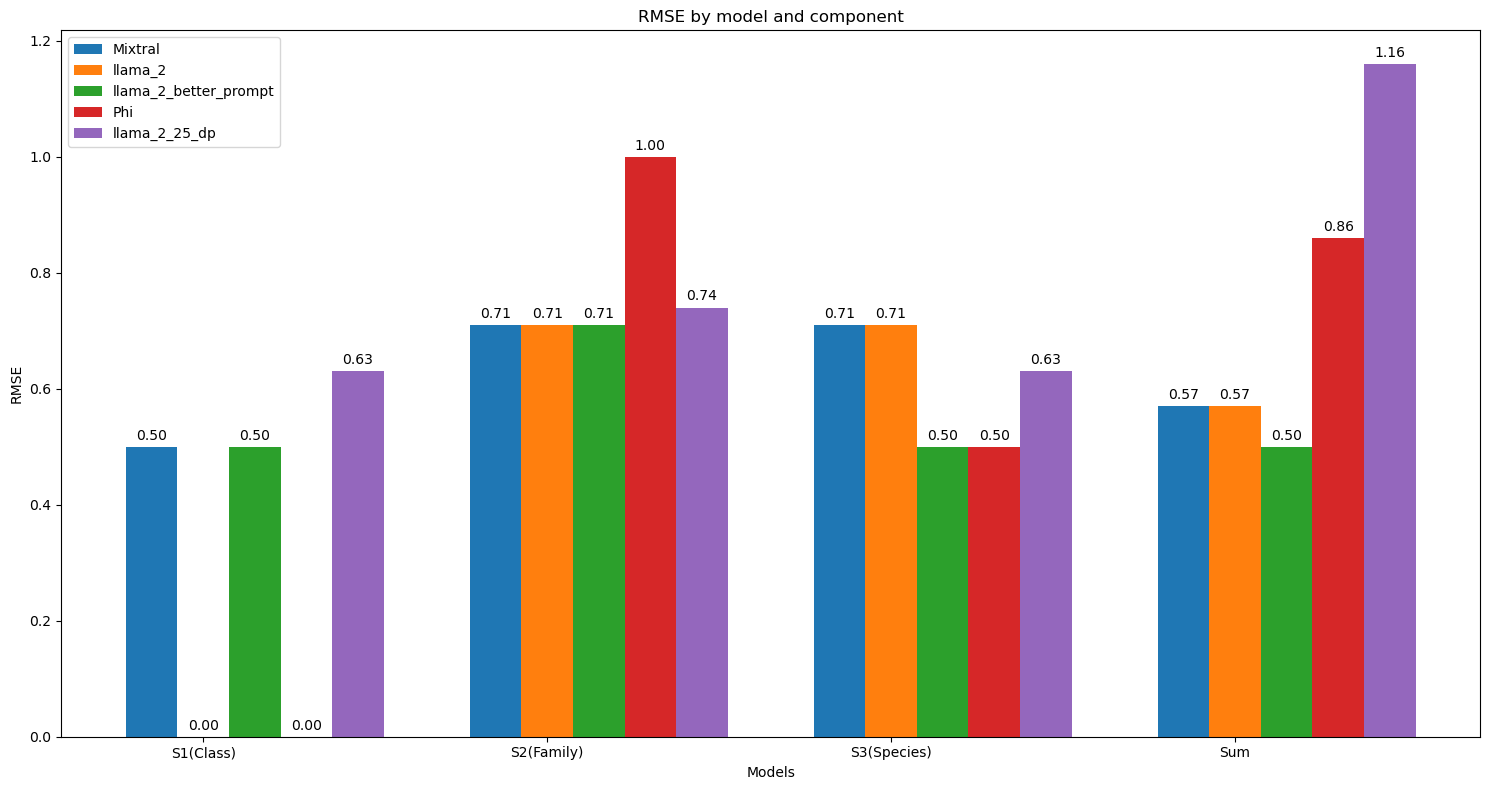

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
#models = ['(Mixtral)', '(Llama-2)', '(Llama-2 better-prompt)', '(Phi-medium)', '(Llama-2 25-data points)']
#rmse_sum = [0.57, 0.57, 0.5, 0.86, 1.16]
#rmse_s1 = [0.5, 0, 0, 0, 0.63]
#rmse_s2 = [0.71, 0.71, 0.71, 1, 0.74]
#rmse_s3 = [0.71, 0.71, 0.5, 0.5, 0.63] 

metrics = ['S1(Class)', 'S2(Family)', 'S3(Species)', 'Sum']
mixtral = [0.5, 0.71, 0.71, 0.57]
llama_2 = [0, 0.71, 0.71, 0.57]
llama_2_better_prompt = [0.5, 0.71, 0.5, 0.5]
phi = [0, 1, 0.5, 0.86]
llama_2_25_dp = [0.63, 0.74, 0.63, 1.16]

x = np.arange(len(metrics))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width, mixtral, width, label='Mixtral')
rects2 = ax.bar(x , llama_2, width, label='llama_2')
rects3 = ax.bar(x + width, llama_2_better_prompt, width, label='llama_2_better_prompt')
rects4 = ax.bar(x + 2*width, phi, width, label='Phi')
rects5 = ax.bar(x + 3*width, llama_2_25_dp, width, label='llama_2_25_dp')


# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model and component')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add values on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)
add_labels(rects5)



fig.tight_layout()

plt.show()